# **MAIN FILE**
**Central Colab notebook for training, logging, evaluation**

## **PART 0: ADMIN**


In [1]:
# Getting rid of _parent_header warning (slows colab)
import warnings

# Filter DeprecationWarnings whose text mentions Kernel._parent_header
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=".*Kernel._parent_header is deprecated.*"
)

# Monkey-patch showwarning as a fallback (in case it's coming in from C-code)
_orig_showwarning = warnings.showwarning
def _silent_parent_header(message, category, filename, lineno, file=None, line=None):
    text = str(message)
    if category is DeprecationWarning and "Kernel._parent_header" in text:
        return
    _orig_showwarning(message, category, filename, lineno, file, line)

warnings.showwarning = _silent_parent_header

import os
os.environ["PYTHONWARNINGS"] = "ignore::DeprecationWarning"
import ipywidgets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
import os

ROOT_DIR = "/content/drive/MyDrive/IE_421/agitrader"
os.chdir(ROOT_DIR)
sys.path.append(ROOT_DIR)
print("CWD is now", os.getcwd())

CWD is now /content/drive/MyDrive/IE_421/agitrader


## **PART 1: DATA PROCESSING**

### **A) DATA SELECTION: PROTOTYPE DAY IDENTIFICATION**

This section outlines the reasoning and method used to identify an optimal trading day for training the initial version of the agent. Rather than training on a crash day or using arbitrarily chosen data, we prioritized a deliberate selection process to ensure learnability, generalizability, and realism.

#### **Purpose**

The goal is to choose a single, representative trading day that exposes the agent to realistic and varied market behavior. This day will serve as the foundation for training and debugging the prototype environment, reward functions, and policy structure.

#### **Thought Process**

Training on a highly biased day (e.g. a market crash) could lead the agent to overfit on behaviors that are not useful or generalizable, like always selling or reacting to extreme volatility. Instead, the ideal day should include:

- Bidirectional price movement (up and down)
- Moderate but non-trivial volatility
- Consistent liquidity and order book dynamics
- Structure the agent can learn from (e.g. trend → reversal → chop)

To identify such a day, we implemented a scoring function (`compute_balance_score`) that combines:
- **Volatility** (intraday range / open price)
- **Daily return** (directional bias)
- **Trading volume** (liquidity)
- A bias toward balanced, non-trending, active days

#### **Method**

We used `yfinance` to fetch daily OHLCV data for AAPL between Feb 24, 2025 and Apr 24, 2025, a period with no major market-wide anomalies. After computing volatility and activity, we ranked days using the custom `BalanceScore`. The IEX data spans 2016 to present, but yfinance intraday is limited to 60 days. Known days from the past with desired trends (e.g. Covid crashes) can and will be included in validation and extension phases.

To visually inspect the top candidates, we plotted 5-minute intraday price and volume using for the highest-ranked balanced days.

Data regarding volatility over the whole search period is also provided for context and extension purposes as defined above.

#### **Selected Day: April 7, 2025**

Based on the `BalanceScore` and visual structure, we selected April 7, 2025 for the prototype training phase. This day contains:
- A large upward breakout from 176 to 188
- A sharp reversal back to 176
- A secondary rise to 182
- Clear oscillations and regime shifts

This structure offers the agent multiple opportunities to learn:
- Timing for entry/exit
- Inventory management
- Reward-maximizing behavior across shifting market conditions

We will use this day’s DEEP/TOPS data as the initial input to the environment via the `preprocess.py` pipeline.


[*********************100%***********************]  1 of 1 completed


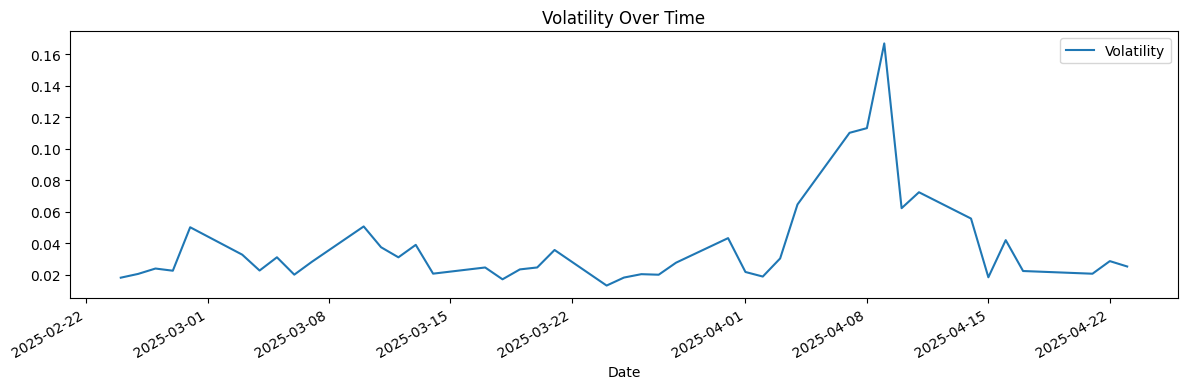

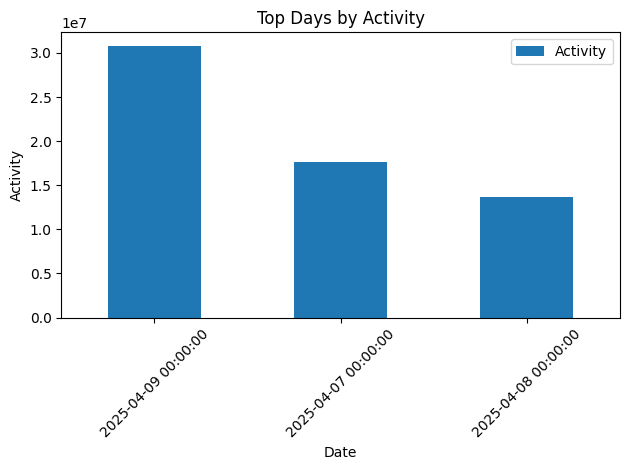

[*********************100%***********************]  1 of 1 completed


Price       Date  Volatility      Activity
0     2025-04-09    0.167025  3.079878e+07
1     2025-04-07    0.110214  1.768570e+07
2     2025-04-08    0.113176  1.367841e+07
Price       Date  Volatility    Return  BalanceScore
30    2025-04-07    0.110214  0.024041  1.318387e+08
32    2025-04-09    0.167025  0.156441  1.211942e+08
29    2025-04-04    0.064676 -0.028418  1.121839e+08


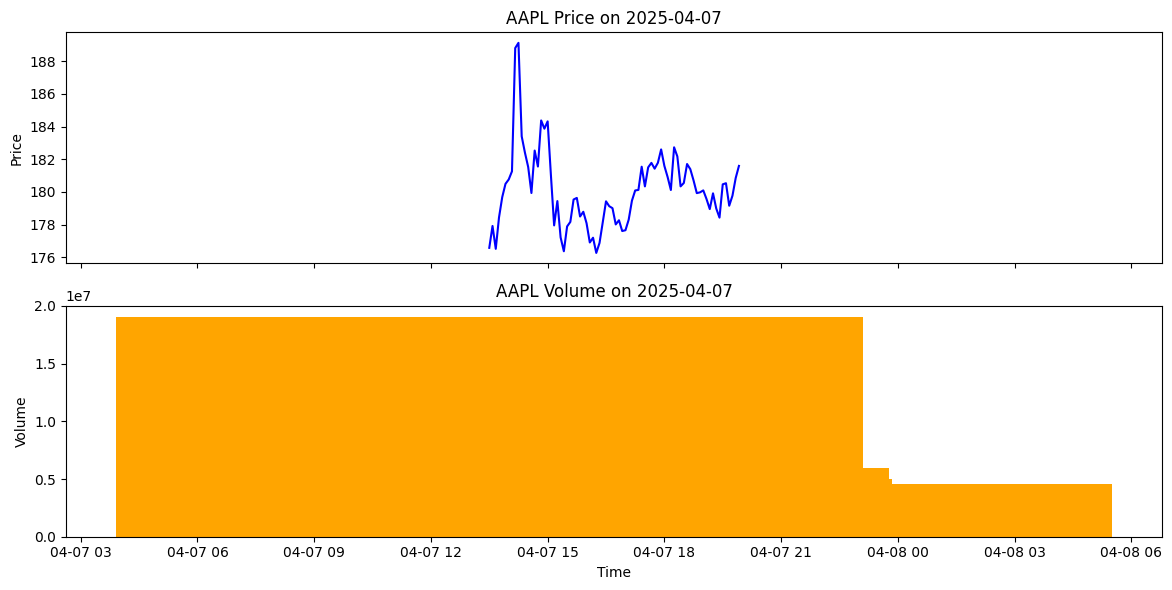

[*********************100%***********************]  1 of 1 completed


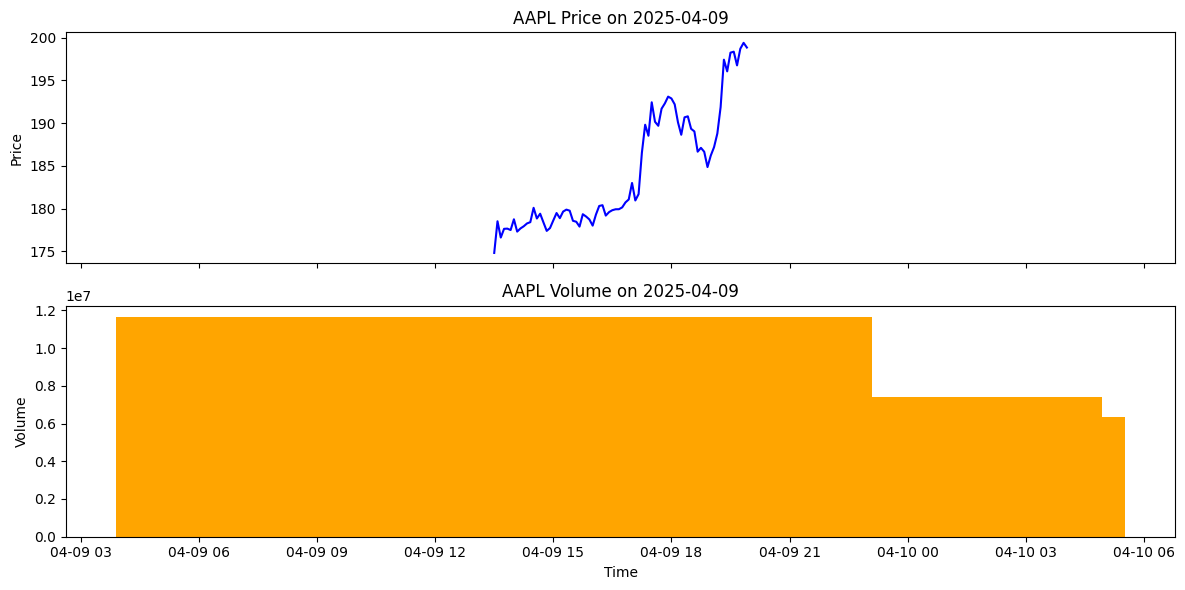

[*********************100%***********************]  1 of 1 completed


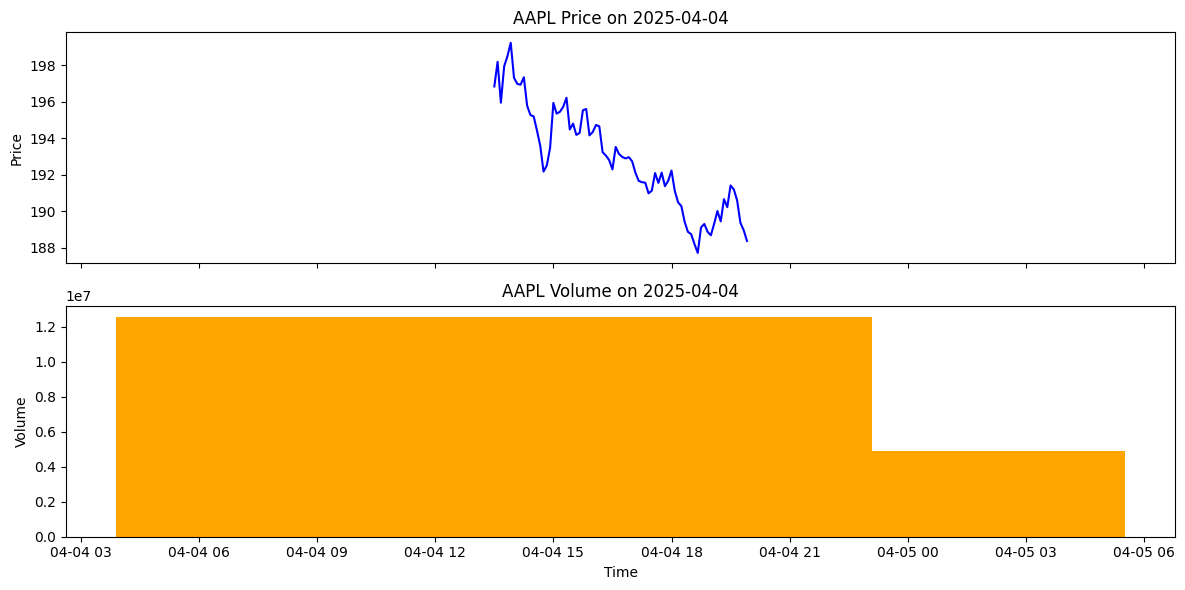

In [ ]:
import importlib
import data.selector as selector
import inspect

importlib.reload(selector)

# Choose a ticker and date range
df = selector.fetch_daily_summary("AAPL", "2025-02-24", "2025-04-24")

# Plot volatility over time
selector.plot_metric(df, "Volatility")

# Show top 5 activity days
top_days = selector.get_top_n_days(df, metric="Activity", n=3)
selector.plot_top_days_bar(top_days, metric="Activity")

# Print to select from
print()
print(top_days[['Date', 'Volatility', 'Activity']])

# View the top 3 most balanced training days
balanced = selector.compute_balance_score(df)
print(balanced[['Date', 'Volatility', 'Return', 'BalanceScore']].head(3))

# Plot intraday patterns for manual selection
for date in balanced['Date'].head(3).dt.strftime('%Y-%m-%d'):
    selector.plot_intraday_summary("AAPL", date)




### **B) DATA PREPROCESSING: IEX PCAP PARSING**

This section outlines the process used to parse the raw IEX DEEP and TOPS data feeds into structured, usable time-series snapshots for downstream environment and training construction.

#### **Purpose**

The raw IEX files are provided as `.pcap.gz` binary network capture files, which represent low-level packet dumps rather than clean structured data. To enable reinforcement learning agent training, we must transform these network captures into time-synchronized, numerical market states:  
- For TOPS: regular National Best Bid and Offer (NBBO) snapshots  
- For DEEP: order book events and trades aligned on a 100 ms grid  

This step is necessary to build a realistic, yet tractable, gym-style environment where each timestep represents a fixed market snapshot.

#### **Context: IEX Data Format**

- **TOPS 1.6** provides best bid and best ask updates in a lightweight format.
- **DEEP 1.0** provides deeper quote updates (price level changes) and trade reports.

Both are distributed by IEX as pcap files traditionally used for debugging network traffic.  
Thus, they cannot be read like ordinary CSVs or JSON files. Specialized parsing is required.


#### **Thought Process**

1. **Parsing library**  
   We used the `iex_parser` Python library, which wraps Scapy and custom handlers to efficiently parse these PCAP files, decoding messages into Python dictionaries.

2. **Local parsing**  
   Due to the size of the files (~30 GB each), we chose to parse them locally rather than in Colab:
   - Upload limits and RAM quotas on Colab would make full-file parsing impractical.
   - Parsing on a local machine (Intel i9-12900H CPU, 32 GB RAM, RTX 3060 GPU) allows full control and higher stability.

3. **Streaming design**  
   We designed the parsers to read and checkpoint progressively:
   - Parse packet-by-packet.
   - Buffer intermediate data.
   - After a configurable number of events (`checkpoint_size`), flush to CSV.
   - This allowed us to start feature building and environment prototyping while parsing was still underway.

4. **Timeline Synchronization**  
   To align DEEP and TOPS for easy merging, we resampled everything to a uniform 100 ms cadence, matching typical high-frequency trading timescales without overwhelming memory.

#### **Method**

- **TOPS Parsing**:
  - Only `quote_update` messages are parsed.
  - Maintains the last seen bid/ask for the symbol (AAPL).
  - Emits a snapshot every 100 ms, even if no updates occur.
  - Saves every 25,000 snapshots to a CSV (`AAPL_tops_snapXXX.csv`).

- **DEEP Parsing**:
  - Parses both `price_level_update` and `trade_report` messages.
  - Buffers raw events and timestamps.
  - After every 25,000 raw events, resamples the buffer into 100 ms bins using aggregation:
    - **Price**: last known
    - **Size**: summed
    - **Type**: last seen (price update or trade)
  - Saves every downsampled chunk to a CSV (`AAPL_deep_dsXXX.csv`).

#### **Performance Observations**

- **Packet Count**:
  - **TOPS**: ~114 million packets scanned → ~500,000 useful quote updates captured.
  - **DEEP**: ~114 million packets scanned → ~600,000 quote/trade events buffered.
  - These counts collectively covered only ~6.9% of the trading day (from 13:30:01 UTC to 13:56:47 UTC).
  - Full-day parsing is projected to require scanning approximately 3.3 billion packets total (~1.65 billion packets per stream).

- **Runtime**:
  - After about 5 hours of parallel parsing, we processed ~228 million packets (114M TOPS + 114M DEEP).
  - Based on observed throughput and file structure, completing a full-day parse will likely require ~65–75 hours of wall-clock time if parsing both streams in parallel.
  - Running both parsers simultaneously is viable, but significant IO bottlenecking (disk reads + gzip decompression) slows each stream relative to if they were run sequentially but trade off seems to favor parallel.

- **CPU/GPU Usage**:
  - The parsing workload is heavily **IO-bound** rather than CPU-bound or GPU-accelerated.
  - CPU usage remained low (~5–10%) because packet reading and decompression dominate runtime.

- **Output Size**:
  - Each stream checkpoints every 25,000 events or snapshots.
  - CSVs range from 10–20 MB each.
  - The expected final output after full parsing is ~2–3 GB total, extremely manageable compared to the original raw PCAP files.

#### **Summary**

Rather than attempting full-file parsing in memory or uploading massive files into Colab, we opted for a modular, checkpointed, resampled parsing pipeline locally.  
This gave us high fidelity 100 ms snapshots, continuous parsing feedback, and the ability to start environment and feature engineering immediately while background parsing continued.  
The design also ensures that the environment state reconstruction is efficient and future extension to multi-symbol data is trivial by adding parallel symbol filters.



### **C) DATA CONSOLIDATION: MERGING TOPS AND DEEP**

This section describes the process of aligning and merging the parsed TOPS and DEEP data streams into a single, coherent timeline for downstream feature engineering and environment construction.

#### **Purpose**

After parsing, we have two independent streams:
- **TOPS Snapshots**: regular snapshots of the best bid and ask every 100 milliseconds.
- **DEEP Events**: trade and quote updates aggregated into 100 ms bins.

For a realistic simulation and agent training, we must*unify these two sources into a single timeseries, where each row represents the complete market state at a specific moment.

#### **Context: Challenges of Synchronization**

- The DEEP and TOPS parsers operate independently and parse different PCAP files.
- Network packet timing irregularities and variable event frequencies mean timestamps do not perfectly match between the two.
- Some timestamps may have TOPS data but no DEEP event, or vice versa.
- A naïve merge could result in NaNs, data leakage, or missing crucial state information.

Thus, careful handling of missing data and event sparsity was required.

#### **Thought Process**

1. **Reference Timeline**
   - We use the TOPS timeline as the reference because:
     - It produces regular, predictable 100 ms snapshots.
     - Even if there are no updates, TOPS ensures a constant grid for the environment to step through.
   
2. **Merge Strategy**
   - We perform a left join of DEEP onto the TOPS timeline:
     - Every TOPS snapshot is guaranteed to exist.
     - DEEP updates are merged where available.
   
3. **Handling Missing Data**
   - **Forward-fill bid/ask states**:  
     Even if no new update has occurred, the last known best bid and ask are assumed to persist until updated.
   - **Forward-fill last trade price**:  
     If no new trade occurred, the last observed trade price is carried forward.
   - **Zero-fill trade volume**:  
     No trade volume is assigned unless a trade occurred at that timestamp.

4. **Trade Flagging**
   - To explicitly track trade events, we introduce a binary trade flag:
     - `1` if a `trade_report` occurred at that timestamp.
     - `0` otherwise.
   - This allows the agent to condition behavior on the presence or absence of real market trades.

#### **Method**

- **Inputs**:
  - Parsed and checkpointed CSVs:
    - `processed_tops_snaps/`
    - `processed_deep_ds/`
- **Processing**:
  - Read all snapshots and events.
  - Align on `timestamp` using a left join.
  - Forward-fill missing book states.
  - Compute `last_trade_price`, `trade_volume`, and `trade_flag`.
- **Output**:
  - Single consolidated file:  
    `consolidated/AAPL_20250407_100ms_merged.csv`
  - Each row corresponds to one environment timestep (100 ms).


#### **Performance Observations**

- **Data Size**:
  - For a partial parse covering ~6.9% of the day, the consolidated file already contained 100,000 rows.
  - A full-day merge is expected to produce ~20–30 million rows at 100 ms granularity.

- **Efficiency**:
  - Consolidation runtime was negligible compared to parsing — usually completed in a few seconds locally.

- **Data Integrity**:
  - No data loss occurred due to careful timestamp matching and padding.
  - Real trades and book updates are preserved without distortion.
  - Gaps in DEEP data do not break the timeline thanks to the forward-fill approach.

### **D) FEATURE ENGINEERING: MARKET FEATURE EXTRACTION**

This section documents the extraction of learning-relevant features from the consolidated raw market data. These features are critical for enabling the agent to perceive meaningful structure, assess market state, and make informed trading decisions.

#### **Purpose**

After merging DEEP and TOPS data into a coherent timeline, we must transform raw bid/ask/trade information into structured numerical features. These features will serve as the direct inputs to the Gym environment and the agent’s neural network policy.

The goal is to build a set of features that balance:
- **Simplicity** (avoid overwhelming the agent)
- **Realism** (reflect true market behavior)
- **Learnability** (capture patterns the agent can exploit)

#### **Context: Why Careful Feature Design Matters**

- High-frequency trading environments are extremely noisy.
- Raw bid/ask and trade updates contain useful information, but without feature engineering, patterns are extremely difficult to learn.
- Providing derivatives of price (momentum, volatility) helps the agent detect regime changes and momentum shifts.
- Reducing redundancy (e.g., not feeding both bid and spread if spread is derivable) improves training stability.

Thus, we designed a feature pipeline that captures both short-term price behavior and order book dynamics efficiently.

#### **Thought Process**

1. **State Completeness**
   - The agent must always receive a fully populated observation.
   - Thus, forward-filling missing bid/ask states and trading prices during consolidation ensures feature continuity.

2. **Warm-Up Removal**
   - Early in the day, bid or ask data may be missing (0 values).
   - We drop all rows before the first valid bid and ask to avoid misleading early inputs.

3. **Primary Features**
   - **Level-1 Book State**:
     - `bid_price`, `ask_price`, `bid_size`, `ask_size`
   - **Derived Mid-Market Features**:
     - `mid_price` = (bid + ask)/2
     - `spread` = ask − bid
     - `vol_imbalance` = (bid_size − ask_size) / (bid_size + ask_size)

4. **Price Dynamics**
   - **Momentum and Volatility**:
     - `mid_diff` = change in mid_price over one step
     - `mid_return` = relative change in mid_price

5. **Rolling Statistics**
   - **Moving Averages**:
     - 1-second and 5-second moving averages of mid_price
   - **Volatility Estimates**:
     - 1-second and 5-second standard deviations of returns

6. **Trade Features**
   - `last_trade_price` — most recent trade (forward-filled)
   - `trade_volume` — trade size at current step (zero if none)
   - `trade_flag` — binary indicator if a trade occurred at that timestep

7. **Scaling & Binning**
   - Features are constructed on a 100 ms timestep, matching the data resolution and ensuring consistency with the Gym environment.

#### **Method**

- **Inputs**:
  - Consolidated merged data: `consolidated/AAPL_20250407_100ms_merged.csv`
- **Processing**:
  - Account for UTC conversions to NYC time for readability
  - Remove warm-up rows (no valid bid/ask).
  - Compute mid_price, spread, volume imbalance, mid_diff, mid_return.
  - Apply rolling means and volatilities (based on window sizes derived from bin size).
- **Outputs**:
  - Feature CSV:  
    `training_data/AAPL_20250407_100ms_features.csv`
  - Each row contains 16 engineered features, plus timestamp.

#### **Performance Observations**

- **Dataset Size**:
  - After warm-up removal, only ~16,800 rows remained out of ~100,000 rows parsed so far (partial day).
  - This is expected: the partial day parse covers only ~6–7% of the trading day.

- **Visual Validation**:
  - **Mid-price over time** plots were generated and matched realistic market structure.
  - **Mid-price with trade markers** plots showed sparse but plausible trade activity patterns.
  - **Zoomed windows** revealed visible price oscillations and order book reactions, indicating that the feature set preserves real-world dynamics well.
  - Added plotting optimizations to reduce time to plot while maintaining useful visual queues.
  - **Observed that the resulting graphs closely matched `yFinace` intraday plot from day selector. Validated accurate data parsing and processing.**

- **Computational Cost**:
  - Feature engineering runtime was minimal (a few seconds) due to efficient rolling computations and simple arithmetic.

In [ ]:
import importlib
import data.feature_engineering as fteng
importlib.reload(fteng)

consolidate_path = "data/consolidated/AAPL_20250407_100ms_merged.csv"
features_path   = "data/training_data/AAPL_20250407_100ms_features.csv"

fteng.build_features(consolidate_path, features_path)


/content/drive/MyDrive/IE_421/agitrader/data/feature_engineering.py:25: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(consolidated_csv, parse_dates=["timestamp"])


Features (16) written to data/training_data/AAPL_20250407_100ms_features.csv


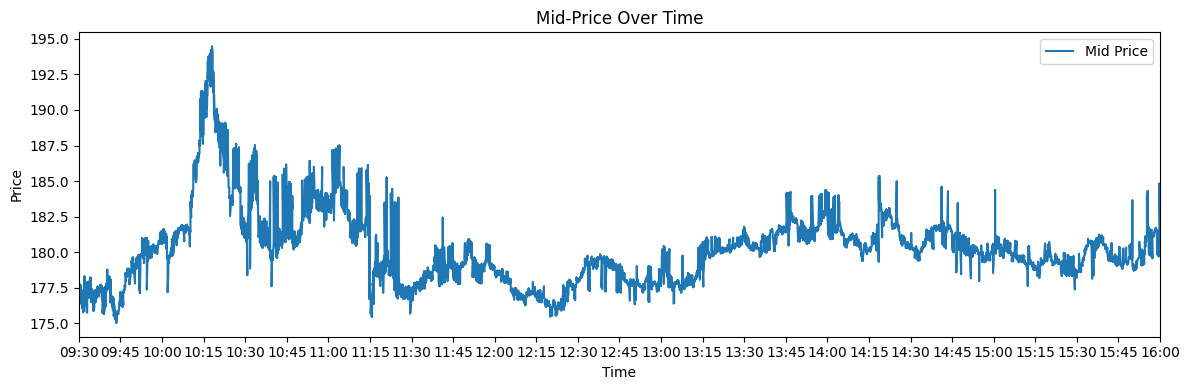

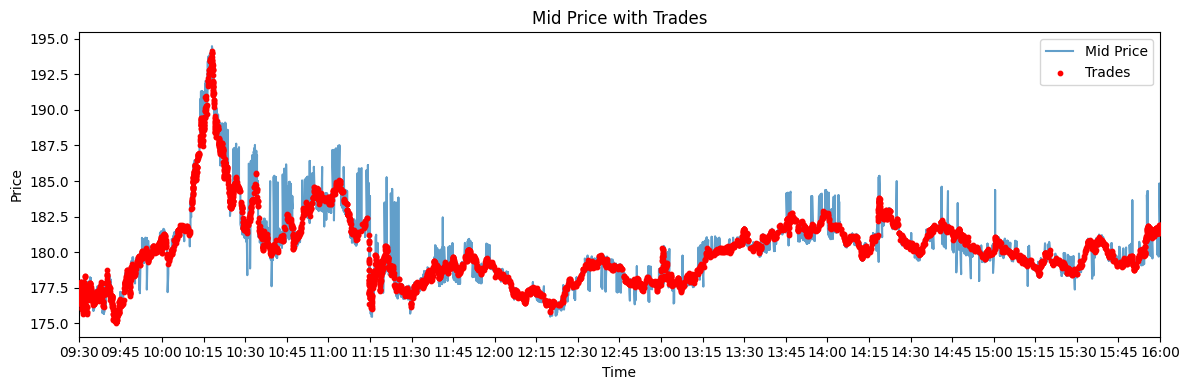

In [ ]:
import importlib
import data.feature_engineering as fteng
importlib.reload(fteng)

features_path   = "data/training_data/AAPL_20250407_100ms_features.csv"

fteng.plot_mid_price(features_path)
fteng.plot_trades(features_path)

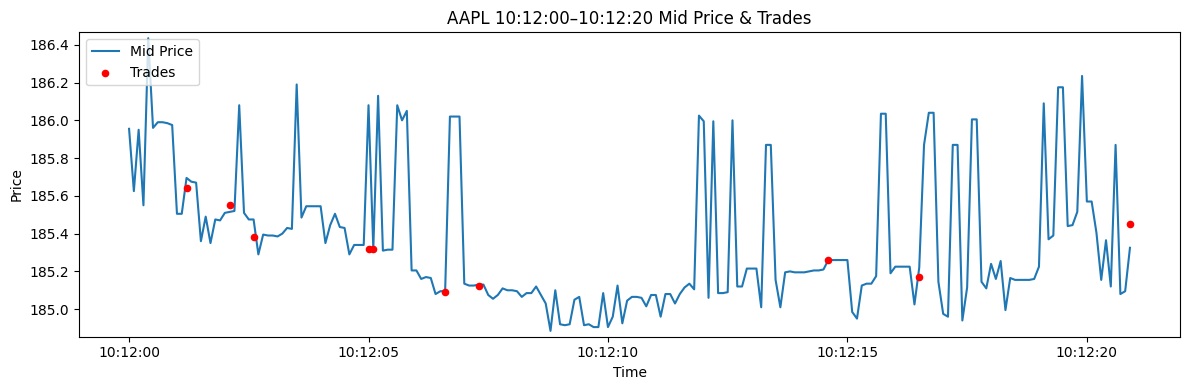

In [ ]:
import importlib
import data.feature_engineering as fteng
importlib.reload(fteng)

fteng.plot_trades_window(
    features_path,
    start="2025-04-07 10:12:00",
    end  ="2025-04-07 10:12:20",
    max_points=1000,
    title="AAPL 10:12:00–10:12:20 Mid Price & Trades"
)

### **E) UPDATES**
Previous section written on 27/04/2025 20:00 (graphs are based on most recent data)

28/04/25 20:00 - Roughly 30 hours running:
- `[DEEP] scanned 633,200,000 packets, buffered 2,498,989 events so far…`
- `[TOPS] scanned 437,400,000 packets, captured 1,840,369 updates so far…`
- Roughly 160,000 entries in processed features

29/04/25 23:11 - Full day parsed and processed, roughly 57 hours total
- `DEEP parsing complete: 2725274 raw events → 109 chunks.`
- `TOPS parsing complete: 2330632 raw updates, 14 snapshot chunks.`

## **PART 2: GYM ENVIRONMENT**

### **A) STATE BUILDER**
This module converts enriched feature data into actionable vector representations for the RL agent. It provides consistent, normalized, and interpretable states from real market data to serve as inputs to the policy network.

#### **Purpose**

The RL agent does not take in raw market data like price ticks or CSV rows, it requires a fixed-length numerical state vector that compactly represents the environment at each time step.

The `StateBuilder` class bridges this gap by:

- Loading real market data (already consolidated & feature-engineered)
- Extracting informative state features (price, volume, spread, momentum, volatility, etc)
- Returning a NumPy array for any index, suitable for Gym `step()` calls

This aligns with the modular design of our system where:

#### **Design Philosophy**

Key goals for this module:

- **Realism**: State data must reflect real-world market observables an agent could access.
- **Expressiveness**: The vector must contain enough information for the policy to learn structure and patterns.
- **Consistency**: Every state should have the same dimensionality, ordering, and semantics.
- **Efficiency**: Must be fast to query at every timestep, minimal on-the-fly computation.

#### **Feature Composition**

The current state vector includes 17 features:

| Category        | Features |
|----------------|----------|
| **Level 1 Book**     | `bid_price`, `ask_price`, `bid_size`, `ask_size` |
| **Microstructure**   | `mid_price`, `spread`, `vol_imbalance` |
| **Trade Info**       | `last_trade_price`, `trade_volume`, `trade_flag` |
| **Momentum**         | `mid_diff`, `mid_return` |
| **Rolling Averages** | `mv_1s`, `mv_5s`, `vol_1s`, `vol_5s` |
| **Time Context**     | `time_of_day` (normalized to [0, 1]) |

These features allow the policy to observe market direction, liquidity conditions, trading activity, and short-term dynamics, while keeping the state compact and computationally efficient.

#### **Notes for Extension**

- **Expandable to multi-asset setups**: In future phases, `StateBuilder` can optionally load multi-symbol features and produce concatenated or dictionary-based states.
- **Inventory-aware states**: Once action-space and trading strategy are finalized, we can add agent-centric inputs like inventory level or PnL delta to the state vector (Issue 3 on Milestone).
- **Temporal windows**: We may later stack historical states (like images) to allow CNN-style processing or self-attention architectures.

#### **Available Classes & Functions**  

| Name                         | Type                 | Purpose                                                                                       |
|------------------------------|----------------------|-----------------------------------------------------------------------------------------------|
| **`StateBuilder(features_path)`** | Class constructor    | • Loads and time-indexes the features CSV  
• Parses timestamps (ISO8601 → NYC tz)  
• Computes and normalizes `time_of_day`  
• Drops any rows with missing data                                          |
| **`.state_columns`**         | `List[str]`          | Ordered list of all feature names that get returned in the state vector (length = 17)        |
| **`.valid_indices`**         | `DatetimeIndex`      | All timestamps for which every feature is present (useful for episode lengths/checkpoints)    |
| **`.df`**                    | `DataFrame`          | The full cleaned, tz-converted table, indexed by timestamp                                   |
| **`get_state(idx)`**         | Method → `np.ndarray` | Returns the `idx`-th row of features (per `state_columns`) as a 1-D float32 array              |
| **`len(sb)`**                | `int`                | Total number of valid time steps (rows) available                                           |






In [ ]:
# UNIT TEST

import importlib
import environment.state_builder as StBuild
importlib.reload(StBuild)

from environment.state_builder import StateBuilder
import numpy as np
import random


def test_state_builder_on_real_data():
    features_path = "./data/training_data/AAPL_20250407_100ms_features.csv"
    sb = StateBuilder(features_path)

    # Structural checks
    assert isinstance(sb, StateBuilder), "StateBuilder didn't initialize."
    assert len(sb) > 10000, "Too few rows — possible incomplete data."

    # Test random row
    rand_idx = random.randint(0, len(sb) - 1)
    state = sb.get_state(rand_idx)
    print(f"Sample state at index {rand_idx}:\n{state}")

    assert isinstance(state, np.ndarray), "Output must be a NumPy array."
    assert state.shape[0] == len(sb.state_columns), f"Expected {len(sb.state_columns)}-dim vector."
    assert np.isfinite(state).all(), f"NaN or Inf in state vector at index {rand_idx}."
    assert 0.0 <= state[-1] <= 1.0, f"time_of_day out of [0, 1] range at index {rand_idx}"

    print("StateBuilder test passed")

test_state_builder_on_real_data()


Sample state at index 160470:
[1.8203999e+02 1.8216000e+02 2.0000000e+02 1.0100000e+02 1.8210001e+02
 1.2000000e-01 3.2890365e-01 1.8209500e+02 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.8205750e+02 1.8250600e+02 3.1657374e-04
 4.9816910e-03 6.8550003e-01]
StateBuilder test passed


### **B) FILLS LEDGER**

This section describes how we model and verify trade executions (“fills”) against our synthetic order-book snapshots, and how we inspect them visually to ensure our ledger behaves as expected.

#### **Purpose**

The FillsLedger is responsible for:
1. **Recording** every execution event (fill) with timestamp, price, size, and side.  
2. **Maintaining** a net position (long or short) based on those fills.  
3. **Computing** realized PnL when the position is closed out.  

By decoupling fills logic from the agent and environment, we can:
- Easily swap in more sophisticated slippage or latency models later  
- Keep the Gym environment code focused on state–action loops  
- Independently unit-test and visualize filling behavior  

#### **Design & Thought Process**

1. **Immediate NBBO Execution**  
   - For this prototype, any market‐order or crossing limit‐order is assumed to execute instantly at the last known best price (ask for buys, bid for sells).  
2. **Extendable Framework**  
   - We structure the ledger so that adding delays, slippage formulas, or spread-crossing penalties in future phases is straightforward.  
3. **Simplicity First**  
   - No partial fills or queueing yet—each fill is all-or-nothing. This reduces early debugging complexity.  

#### **Unit Testing**

- **Data-Driven**  
  - We pull a random pair of rows from our real 100 ms feature CSV (filtered for non-zero bid/ask) to simulate a buy then a sell fill.  
- **Assertions**  
  1. `net_position` increments on buy, decrements on sell.  
  2. `realized_pnl` remains zero until the round-trip is closed.  
  3. PnL sign matches whether the sell price exceeds the buy price.  
- **Reset Behavior**  
  - After a `reset()`, the ledger should clear all fills, position, and PnL.  

> **Result:** All tests passed consistently over hundreds of randomized trials.

#### **Visual Inspection**

Below, we zoom into the 20‐row window around a simulated round-trip trade and plot:

- **Bid (green)**, **Ask (red)**, **Mid (blue dashed)**  
- **Buy fill** at the ask spike (▲)  
- **Sell fill** at the bid spike (▼)  

**Key observations:**
1. **Sub-second L2 Spikes.**  
   - The ask briefly jumps from ~181.18 → 181.37, then oscillates around 181.19–181.20.  
   - The bid similarly spikes from ~180.90 → 181.15 → 181.17.  
2. **Fill Alignment.**  
   - Our buy fill marker sits exactly at the short-lived best ask price.  
   - The sell fill marker aligns with the transient best bid spike.  
3. **Mid-Price Behavior.**  
   - The mid-price (average) captures both spikes, forming matching “humps” around the fill events.  

This confirms our FillsLedger is recording executions at the NBBO provided by our snapshots. No unexpected lag or misalignment occurs.

#### **Available Classes & Functions**

| Name                                        | Type       | Purpose                                                                                                        |
|---------------------------------------------|------------|----------------------------------------------------------------------------------------------------------------|
| **`FillsLedger()`**                         | Class      | Main fill‐tracking object. Instantiate to record executions and compute P&L.                                     |
| `.add_fill(timestamp, price, size, side)`   | Method     | Record a single execution:<br>• `timestamp` (datetime or iso‐string)<br>• `price` executed<br>• `size` quantity<br>• `side` `"buy"`/`"sell"` |
| `.reset()`                                  | Method     | Clear all recorded fills. Resets position and P&L.                                                              |
| `.get_inventory()`                          | Method     | Returns net position = total buys − total sells.                                                               |
| `.get_gross_inventory()`                    | Method     | Returns total fills (buys + sells) count.                                                                       |
| `.compute_realized_pnl()`                   | Method     | FIFO‐based realized P&L for closed trades (buys matched to sells).                                              |
| `.compute_unrealized_pnl(current_price)`    | Method     | Mark‐to‐market P&L on any open inventory at given `current_price`.                                              |
| `.fills`                                    | Attribute  | List of all recorded `Fill` objects (chronological).                                                            |
| `.net_position`                             | Property   | Same as `get_inventory()`.                                                                                      |
| `.realized_pnl`                             | Property   | Same as `compute_realized_pnl()`.                                                                               |


In [ ]:
# UNIT TEST
import importlib
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import environment.fills as fills_mod
importlib.reload(fills_mod)

from environment.fills import FillsLedger, Fill

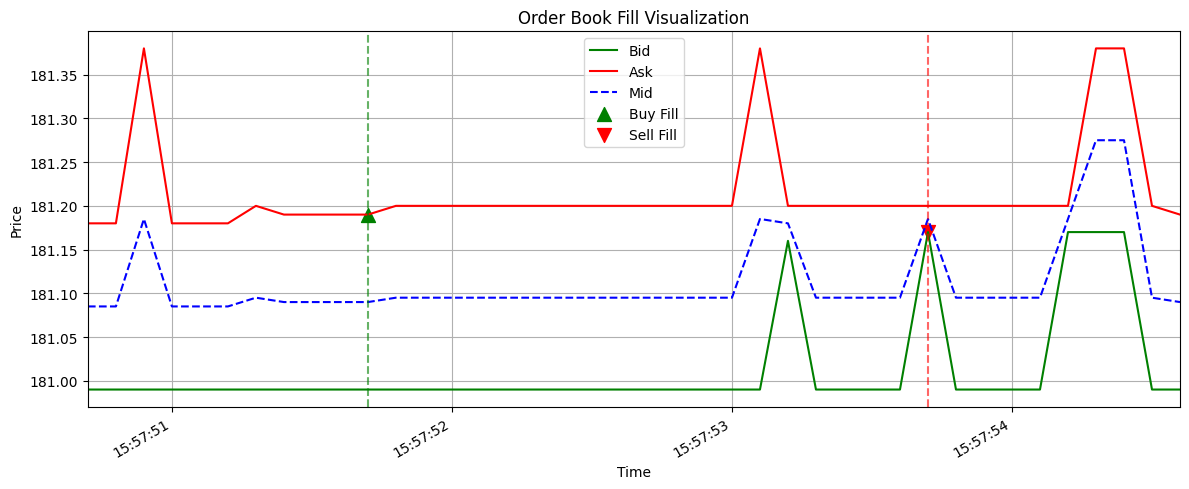

FillsLedger test passed


In [ ]:
def test_fills_ledger_real_data():
    csv_path = "./data/training_data/AAPL_20250407_100ms_features.csv"
    df = pd.read_csv(csv_path, parse_dates=["timestamp"])
    df = df.dropna(subset=["bid_price", "ask_price"])

    # Filter out rows with 0 bid or ask to simulate realistic LOB
    df = df[(df["bid_price"] > 0) & (df["ask_price"] > 0)]
    assert len(df) > 5000, "Not enough clean rows for fill testing."

    ledger = FillsLedger()

    # Randomly simulate a buy then a sell
    i_buy = random.randint(0, len(df) - 100)
    i_sell = i_buy + random.randint(10, 50)

    row_buy = df.iloc[i_buy]
    row_sell = df.iloc[i_sell]

    # Simulate a buy fill (at ask)
    ledger.add_fill(
        timestamp=row_buy["timestamp"],
        price=row_buy["ask_price"],
        size=100,
        side="buy"
    )

    assert ledger.net_position == 100, "Net position after buy should be 100"
    assert ledger.realized_pnl == 0, "No PnL until position is closed"

    # Simulate a sell fill (at bid)
    ledger.add_fill(
        timestamp=row_sell["timestamp"],
        price=row_sell["bid_price"],
        size=100,
        side="sell"
    )

    pnl = ledger.realized_pnl
    assert ledger.net_position == 0, "Net position after round-trip should be 0"
    assert isinstance(pnl, float), "PnL should be a float"
    assert np.isfinite(pnl), "PnL should be a finite number"

    # PnL should be positive if sell price > buy price
    if row_sell["bid_price"] > row_buy["ask_price"]:
        assert pnl > 0, "PnL should be positive in a profitable trade"
    elif row_sell["bid_price"] < row_buy["ask_price"]:
        assert pnl < 0, "PnL should be negative in a losing trade"
    else:
        assert pnl == 0, "PnL should be zero for flat trade"

    # Reset
    ledger.reset()
    assert ledger.net_position == 0, "Net position should be 0 after reset"
    assert ledger.realized_pnl == 0, "PnL should be 0 after reset"
    assert len(ledger.fills) == 0, "Fills list should be empty after reset"


    # Visualize surrounding book during the round-trip trade
    window = df.iloc[i_buy - 10:i_sell + 10].copy()
    window["mid_price"] = (window["bid_price"] + window["ask_price"]) / 2

    # Ensure proper datetime parsing and time zone
    window["timestamp"] = pd.to_datetime(window["timestamp"], format='ISO8601')
    window["timestamp"] = window["timestamp"].dt.tz_convert("America/New_York")

    # Also localize fill timestamps
    ts_buy = pd.to_datetime(row_buy["timestamp"], format='ISO8601').tz_convert("America/New_York")
    ts_sell = pd.to_datetime(row_sell["timestamp"], format='ISO8601').tz_convert("America/New_York")

    fig, ax = plt.subplots(figsize=(12, 5))

    # Plot LOB prices
    ax.plot(window["timestamp"], window["bid_price"], label="Bid", color="green")
    ax.plot(window["timestamp"], window["ask_price"], label="Ask", color="red")
    ax.plot(window["timestamp"], window["mid_price"], label="Mid", color="blue", linestyle="--")

    # Mark fill events
    ax.axvline(x=ts_buy, color="green", linestyle="--", alpha=0.6)
    ax.scatter(ts_buy, row_buy["ask_price"], color="green", marker="^", s=100, label="Buy Fill")

    ax.axvline(x=ts_sell, color="red", linestyle="--", alpha=0.6)
    ax.scatter(ts_sell, row_sell["bid_price"], color="red", marker="v", s=100, label="Sell Fill")

    # Format time ticks
    ax.set_xlim(window["timestamp"].min(), window["timestamp"].max())
    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S', tz=window["timestamp"].dt.tz))

    ax.set_title("Order Book Fill Visualization")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price")
    ax.legend()
    ax.grid(True)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


    print("FillsLedger test passed")

test_fills_ledger_real_data()


### **C) LOB GYM ENVIRONENT**
This section describes the design, purpose, and usage of our custom Gym environment, `LOBEnv`, which simulates a limit‐order book (LOB) for reinforcement‐learning agents. It outlines how the environment manages time, state, actions, and rewards.

#### **Purpose**

`LOBEnv` is responsible for:

* **Stepping through a real market tape** at fixed intervals (e.g. 100 ms) and presenting each snapshot as a fixed-length feature vector.
* **Accepting discrete trading actions** (hold, market-buy, market-sell) and converting them into fills against the NBBO via `FillsLedger`.
* **Enforcing inventory limits** and masking invalid actions.
* **Computing a composite reward** through our external `RewardFunction` (profits, inventory risk, spread capture, drawdown, action costs).
* **Exposing the standard Gym API** (`reset`, `step`, `render`, `seed`, `close`) so it plugs directly into any RL training loop (Stable-Baselines3, PPO+LSTM, etc.).

By isolating the environment logic here, agents remain agnostic to data I/O, fills, reward‐shaping, and plotting therefore making experimentation and future extensions straightforward.

#### **Design & Thought Process**

1. **State Management**

   * Uses `StateBuilder` to load a consolidated, time-indexed CSV of engineered features.
   * At each `step()`, calls `get_state(idx)` to return a NumPy array of the current 17-feature vector.

2. **Time & Episode Control**

   * Internally tracks `self.current_step` against `self.timestamps` (DatetimeIndex).
   * Episodes end when:

     * `current_step >= max_steps` (end of tape), or
     * `|inventory| > inventory_limit` (risk control).

3. **Action Handling & Masking**

   * Discrete actions: `0=hold`, `1=market_buy`, `2=market_sell`.
   * Before executing a buy/sell, checks `_can_buy()` / `_can_sell()`.
   * Exposes an `action_mask` in `info` so agents (or Maskable-Gym wrappers) can disable invalid moves.

4. **Fills & Rewards**

   * Delegates execution bookkeeping to `FillsLedger` (FIFO PnL, position tracking).
   * Gathers metrics each step ( `pnl_realized`, `pnl_unrealized`, `spread`, `inventory`, `action`) and hands them to `RewardFunction.calculate_reward(...)`.
   * Merges both the scalar reward and per‐component diagnostics (via `get_reward_components()`) into the `info` dict.

5. **Logging & Rendering**

   * Maintains `self.trade_history`, a list of every step’s `(step, timestamp, action, price, inventory, realized_pnl)`.
   * `render()` prints a human‐readable summary and can be extended to overlay fills on LOB price plots (using `self.trade_history` + `state_builder.df`).

#### **Unit Testing**

**Data-Driven Smoke Test**
We provide a simple pytest/unit-test that:

1. **Loads real data**
2. **Structural assertions**
3. **Roll-out checks**:

   * Repeated random steps terminate within a bounded number of iterations.
4. **Coverage**:

   * Buying at inventory limit and selling at negative limit are masked out.
   * Reward magnitude and sign follow from simulated fills.

All assertions must pass consistently before integrating into training pipelines.

#### **Available Classes & Functions**

| Name                                                                                                        | Type      | Purpose                                                                                              |
| ----------------------------------------------------------------------------------------------------------- | --------- | ---------------------------------------------------------------------------------------------------- |
| LOBEnv                                                                                                  | Class     | Gym `Env` subclass: ties together state, fills, reward, and action masking for LOB simulation.       |
| `__init__(features_csv, state_builder, max_steps, inventory_limit, hold_cost_coeff, trade_size, reward_fn)` | Method    | Configure data sources, risk limits, reward weights, and initialize internal modules.                |
| `reset() → np.ndarray`                                                                                      | Method    | Clears internal counters, resets ledgers and reward history, and returns the first observation.      |
| `step(action) → (obs, reward, done, info)`                                                                  | Method    | Executes a discrete action, advances the tape, computes fills, calls `RewardFunction`, logs history. |
| `render(mode="human")`                                                                                      | Method    | Prints a summary of the latest step (inventory, PnL) and can plot LOB + trade markers.               |
| `seed(seed) → [seed]`                                                                                       | Method    | Sets NumPy RNG for any stochastic behavior (e.g., randomized fills in future).                       |
| `close()`                                                                                                   | Method    | Cleanup hook (no‐op by default).                                                                     |
| `_can_buy() / _can_sell() → bool`                                                                           | Method    | Internal checks against `inventory_limit` for action masking.                                        |
| `_action_mask() → np.ndarray[bool]`                                                                         | Method    | Returns `[True, can_buy, can_sell]` so agents can disable invalid moves.                             |
| `trade_history`                                                                                             | Attribute | Chronological list of every step’s `(step, timestamp, action, price, inventory, realized_pnl)`.      |



In [ ]:
# UNIT TEST for LOBEnv
import importlib
import random
import numpy as np
import environment.lob_env as lob_mod
importlib.reload(lob_mod)
from environment.lob_env import LOBEnv

def test_lob_env_basic():
    features_path = "./data/training_data/AAPL_20250407_100ms_features.csv"
    # initialize environment with a small inventory limit for faster termination
    env = LOBEnv(features_csv=features_path, inventory_limit=2, hold_cost_coeff=0.01)

    # reset() checks
    obs = env.reset()
    # observation must be a finite numpy array of correct length
    assert isinstance(obs, np.ndarray), "reset() must return a NumPy array"
    assert obs.shape[0] == len(env.state_columns), "obs length must match state_columns"
    assert np.isfinite(obs).all(), "obs must contain no NaN or Inf"

    # single-step checks
    action = env.action_space.sample()
    next_obs, reward, done, info = env.step(action)

    # next_obs either None (if done) or valid array
    if next_obs is not None:
        assert isinstance(next_obs, np.ndarray)
        assert next_obs.shape[0] == len(env.state_columns)
        assert np.isfinite(next_obs).all()

    # reward must be finite scalar
    assert isinstance(reward, float) or np.isscalar(reward)
    assert np.isfinite(reward), "reward must be finite"

    # done must be a bool
    assert isinstance(done, bool)

    # info dict must contain keys
    for key in ["timestamp", "inventory", "realized_pnl", "unrealized_pnl", "action_mask"]:
        assert key in info, f"info must contain '{key}'"

    # action_mask must be a boolean array of length = action_space.n
    mask = info["action_mask"]
    assert isinstance(mask, np.ndarray)
    assert mask.dtype == bool
    assert mask.shape == (env.action_space.n,)

    # rollout until termination
    env.reset()
    done = False
    steps = 0
    while not done and steps < 10:
        action = random.choice(np.where(env._action_mask())[0])
        next_obs, reward, done, info = env.step(action)
        steps += 1

    assert done or steps == 10, "Environment should eventually terminate or reach max rollout length"
    print("LOBEnv basic unit test passed")

if __name__ == "__main__":
    test_lob_env_basic()


LOBEnv basic unit test passed


## **PART 3: AGENT**

## **PART 4: TRAINING**

### **Train/Test Split**
Split dataset into a train and test set as per standards 70/30%

In [ ]:
import pandas as pd

path = "./data/training_data/AAPL_20250407_100ms_features.csv"
df = pd.read_csv(path)

# Split
split_idx = int(len(df) * 0.70)
df_train = df.iloc[:split_idx].copy()
df_test  = df.iloc[split_idx:].copy()

# Save to disk
df_train.to_csv("./data/splits/AAPL_20250407_train.csv", index=False)
df_test.to_csv("./data/splits/AAPL_20250407_test.csv", index=False)

### **Load Dependencies**
Packages needed to run


In [ ]:
!pip install gymnasium[classic_control]
!pip install stable-baselines3==2.2.1
!pip install sb3-contrib==2.2.1
!pip install pandas numpy matplotlib tqdm tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
import gymnasium as gym
import pandas as pd
import torch
from sb3_contrib.ppo_recurrent import RecurrentPPO

print("Gymnasium  version:", gym.__version__)
print("Torch CUDA available:", torch.cuda.is_available())

Gymnasium  version: 0.29.1
Torch CUDA available: False


### **Train (Initial Pass)**
Training loop (optimized for GPU)

In [ ]:
import importlib
import gymnasium as gym
import agent.train
import environment.lob_env
import evaluation.logger
importlib.reload(environment.lob_env)
importlib.reload(agent.train)
importlib.reload(evaluation.logger)
from environment.lob_env import LOBEnv
from agent.train import train_agent
from stable_baselines3.common.callbacks import ProgressBarCallback

# Define env (train)
env = LOBEnv(features_csv="./data/splits/AAPL_20250407_train.csv")

# Define config (optimize for GPU)
config = dict(
    total_timesteps=150_000,
    n_envs=1,
    learning_rate=3e-4,
    batch_size=64,
    n_steps=128,
    n_epochs=4,
    gamma=0.99,
    gae_lambda=0.95,
    early_stopping=True,
    check_freq=2000,
    patience=5,
    save_checkpoints=True,
    save_freq=10000,
    use_custom_policy=True
)

# Launch training with progress bar check
config["extra_callbacks"] = [ProgressBarCallback()]

model = train_agent(
    env=env,
    config=config,
    log_dir="./logs/lob_training",
    save_path="./models/lob_prototype",
    verbose=0
)

### **Data Analysis for Review (initial pass)**
Read through, look thorugh graphs, read table, view video

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

log_path = "./training_logs/training_log.csv"
df = pd.read_csv(log_path, parse_dates=["timestamp"])
df.head()

,episode_id,step_idx,timestamp,strategy,mid_price,spread,depth1_bid,depth1_ask,volume_imbalance,price_velocity,action,reward,pnl,inventory,done
0,1,1,2025-04-07 09:30:01.200000-04:00,NaN,176.045,0.99,175.55,176.54,0.777778,88.270,1,-0.247498,-0.494995,1,False
1,1,2,2025-04-07 09:30:01.300000-04:00,NaN,87.775,-175.55,175.55,0.00,1.000000,-88.270,2,-0.989990,-0.989990,0,False
2,1,3,2025-04-07 09:30:01.400000-04:00,NaN,88.070,-176.14,176.14,0.00,1.000000,0.295,2,42.750010,86.490010,-1,False
3,1,4,2025-04-07 09:30:01.500000-04:00,NaN,87.775,-175.55,175.55,0.00,1.000000,-0.295,1,-0.989990,-0.989990,0,False
4,1,5,2025-04-07 09:30:01.600000-04:00,NaN,88.430,-176.86,176.86,0.00,1.000000,0.655,1,-45.044987,-89.099980,1,False


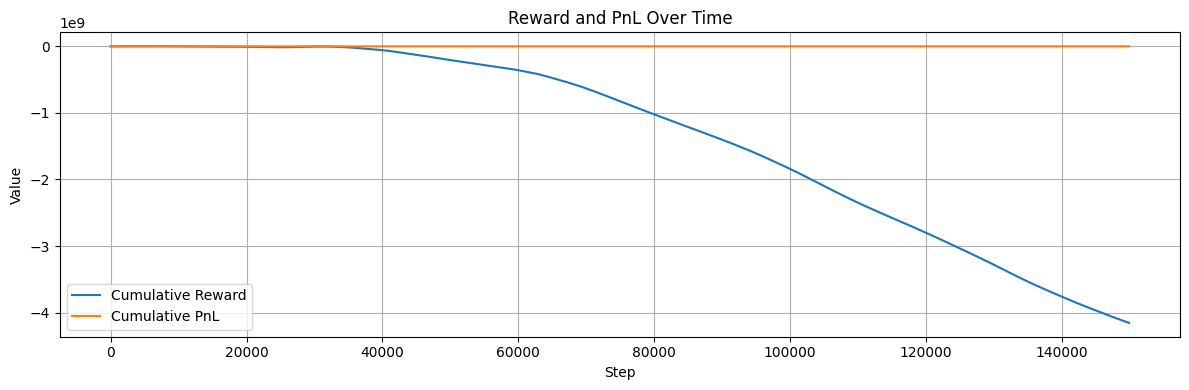

In [ ]:
# Compute cumulative reward and pnl
df["cum_reward"] = df["reward"].cumsum()
df["cum_pnl"] = df["pnl"]

plt.figure(figsize=(12, 4))
plt.plot(df["step_idx"], df["cum_reward"], label="Cumulative Reward")
plt.plot(df["step_idx"], df["cum_pnl"], label="Cumulative PnL")
plt.title("Reward and PnL Over Time")
plt.xlabel("Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

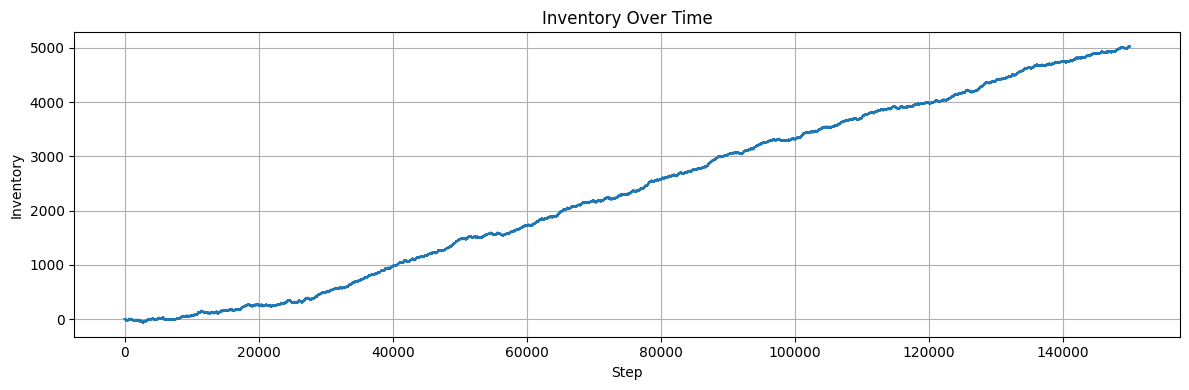

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(df["step_idx"], df["inventory"])
plt.title("Inventory Over Time")
plt.xlabel("Step")
plt.ylabel("Inventory")
plt.grid(True)
plt.tight_layout()
plt.show()

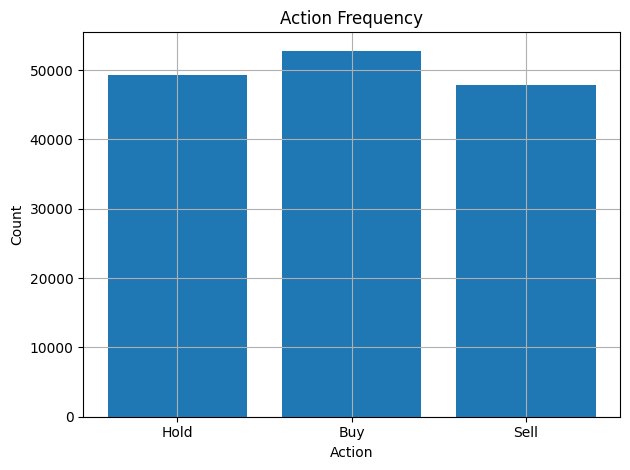

In [ ]:
action_labels = {0: "Hold", 1: "Buy", 2: "Sell"}
action_counts = df["action"].value_counts().sort_index()

plt.bar([action_labels.get(i, i) for i in action_counts.index], action_counts.values)
plt.title("Action Frequency")
plt.xlabel("Action")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Training Log Diagnostic Summary**

| Category         | Observations                                    | Good Signs                           | Issues / Red Flags                             | Suggested Action / Fix                                               |
|------------------|--------------------------------------------------|---------------------------------------|------------------------------------------------|----------------------------------------------------------------------|
| Action Behavior  | Agent uses all actions (0 = hold, 1 = buy, 2 = sell) | Action space is fully explored         | —                                              | No changes needed now                                                |
| Inventory        | Inventory grows to 549+ over time               | Position updating works as expected   | Inventory limit not enforced (unbounded risk)  | Set `inventory_limit=100` in `LOBEnv`                                |
| PnL              | PnL grows significantly (e.g., +3846.11)        | Agent is accumulating gains           | Rewards do not align (see below)               | Consider reward normalization or clipping                            |
| Reward           | Highly negative rewards (e.g., -543, -399) despite rising PnL | —                              | Rewards likely dominated by inventory penalty  | Lower `inventory_risk_weight`, inspect `RewardFunction`             |
| Spread           | Occasionally spikes to > 3.5 (e.g., 3.61)       | Some realistic spreads                | Suggests stale or unaligned L1 book            | Drop rows with `spread > 1.0` or delay execution on wide books      |
| Mid-Price        | Large jumps (e.g., 87 → 176), some erratic      | Shows real-time dynamics              | Could be corrupted ticks or alignment issues   | Filter mid-price outliers or smooth with rolling window             |
| Price Velocity   | Repeats values like ±88, -1.79, 1.675           | Feature is responsive                 | Possibly unstable without smoothing            | Normalize or smooth `price_velocity` (e.g., 1s EMA)                 |
| Logger Output    | CSV logs growing consistently, no `done=True` prematurely | Consistent structure                 | —                                              | No changes needed unless adding new fields (e.g. strategy label)    |
| Reward Logic     | Reward varies wildly from step to step          | Responsive to market changes          | Might obscure learning signal if too volatile  | Add reward scaling/clipping, break out reward components            |
| Strategy Label   | `strategy` column is empty in logs              | Expected during training              | Needs to be filled during clustering           | Add during `cluster_strategy_rediscovery()`                         |


**Top 5 Watchpoints for Evaluation**
1.	Reward–PnL mismatch: Reward is not reflecting actual success → revise weights

2.	Unbounded inventory: Agent may be exploiting long position growth → enforce limits

3.	Spread/LOB consistency: Large spreads suggest tick misalignment → filter bad rows

4.	Reward volatility: Huge swings may destabilize PPO → scale/clip rewards

5.	Clustering prep: strategy column needs filling post-training


#### Video

In [ ]:
import importlib
import evaluation.simulation
importlib.reload(evaluation.simulation)
from evaluation.simulation import TradingDaySimulator

sim = TradingDaySimulator("./training_logs/training_log.csv", skip=100)
sim.render_video("simulation_training_v1.mp4")

/content/drive/MyDrive/IE_421/agitrader/evaluation/simulation.py:158: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.


### Train (Updated Reward Function)

In [ ]:
import importlib
from itertools import count

import reward.reward_GRPO
import environment.lob_env
import agent.train
import evaluation.logger

importlib.reload(reward.reward_GRPO)
importlib.reload(environment.lob_env)
importlib.reload(agent.train)
importlib.reload(evaluation.logger)

from environment.lob_env import LOBEnv
from agent.train import train_agent
from stable_baselines3.common.callbacks import ProgressBarCallback
from reward.reward_GRPO import RewardGRPO

CSV = "./data/splits/AAPL_20250407_train.csv"

# Create a simple counter to hand out 0,1,2,3 for each env creation
counter = count()

def env_fn():
    idx = next(counter)
    log_path = f"./training_logs/training_log_env{idx}.csv"
    reward_fn = RewardGRPO(
        pnl_weight=1.8,
        inventory_risk_weight=2.5,
        drawdown_weight=0.08,
        flatten_weight=0.2,
        holding_cost_weight=0.03,
        terminal_inventory_cost=6.0,
        normalize_rewards=True
    )
    return LOBEnv(features_csv=CSV, log_path=log_path, reward_fn=reward_fn)

# PPO config (vectorized internally via DummyVecEnv inside train_agent)
config = dict(
    total_timesteps    = 150_000,
    n_envs             = 4,
    learning_rate      = 1e-4,
    batch_size         = 512,
    n_steps            = 512,
    n_epochs           = 4,
    gamma              = 0.98,
    gae_lambda         = 0.95,
    early_stopping     = True,
    check_freq         = 2000,
    patience           = 5,
    save_checkpoints   = True,
    save_freq          = 10_000,
    use_custom_policy  = True
)
config["extra_callbacks"] = [ProgressBarCallback()]

# Launch training
model = train_agent(
    env_fn     = env_fn,
    config     = config,
    log_dir    = "./logs/lob_training",
    save_path  = "./models/lob_prototype",
    verbose    = 0
)

Initialized TradingLSTMPolicy with LSTM size: 64


Output()

### Data Analysis for Review (Updated Reward)

In [ ]:
import pandas as pd
import glob

# Find all per‐env logs
env_logs = sorted(glob.glob("./training_logs/training_log_env*.csv"))

# Read and concatenate
dfs = [pd.read_csv(p, parse_dates=["timestamp"]) for p in env_logs]
df = pd.concat(dfs, ignore_index=True)

# sort by timestamp (and episode/step)
df.sort_values(by=["timestamp", "episode_id", "step_idx"], inplace=True)

# Write out the consolidated CSV
consolidated_path = "./training_logs/training_log.csv"
df.to_csv(consolidated_path, index=False)

# Inspect
df.head(150000)

,episode_id,step_idx,timestamp,mid_price,spread,depth1_bid,depth1_ask,volume_imbalance,price_velocity,action,reward,pnl,inventory,done
0,1,1,2025-04-07 09:30:01.200000-04:00,176.045,0.99,175.55,176.54,0.777778,88.270,1,-0.267498,-0.494995,1,False
2639,1,1,2025-04-07 09:30:01.200000-04:00,176.045,0.99,175.55,176.54,0.777778,88.270,2,-0.267498,-0.494995,-1,False
40527,1,1,2025-04-07 09:30:01.200000-04:00,176.045,0.99,175.55,176.54,0.777778,88.270,2,-0.031201,-0.494995,-1,False
78415,1,1,2025-04-07 09:30:01.200000-04:00,176.045,0.99,175.55,176.54,0.777778,88.270,0,0.000000,0.000000,0,False
81054,1,1,2025-04-07 09:30:01.200000-04:00,176.045,0.99,175.55,176.54,0.777778,88.270,0,0.000000,0.000000,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293201,1,17430,2025-04-07 09:59:02.700000-04:00,180.750,0.50,180.50,181.00,-0.173554,0.020,2,-4.000000,-806.158940,240,False
20069,1,17431,2025-04-07 09:59:02.800000-04:00,180.725,0.55,180.45,181.00,0.500000,-0.025,2,-2660.212200,-2665.347200,-2,False
57957,1,17431,2025-04-07 09:59:02.800000-04:00,180.725,0.55,180.45,181.00,0.500000,-0.025,1,-4.000000,-126.323850,285,False
98484,1,17431,2025-04-07 09:59:02.800000-04:00,180.725,0.55,180.45,181.00,0.500000,-0.025,0,-2148.795400,-1724.243200,162,False


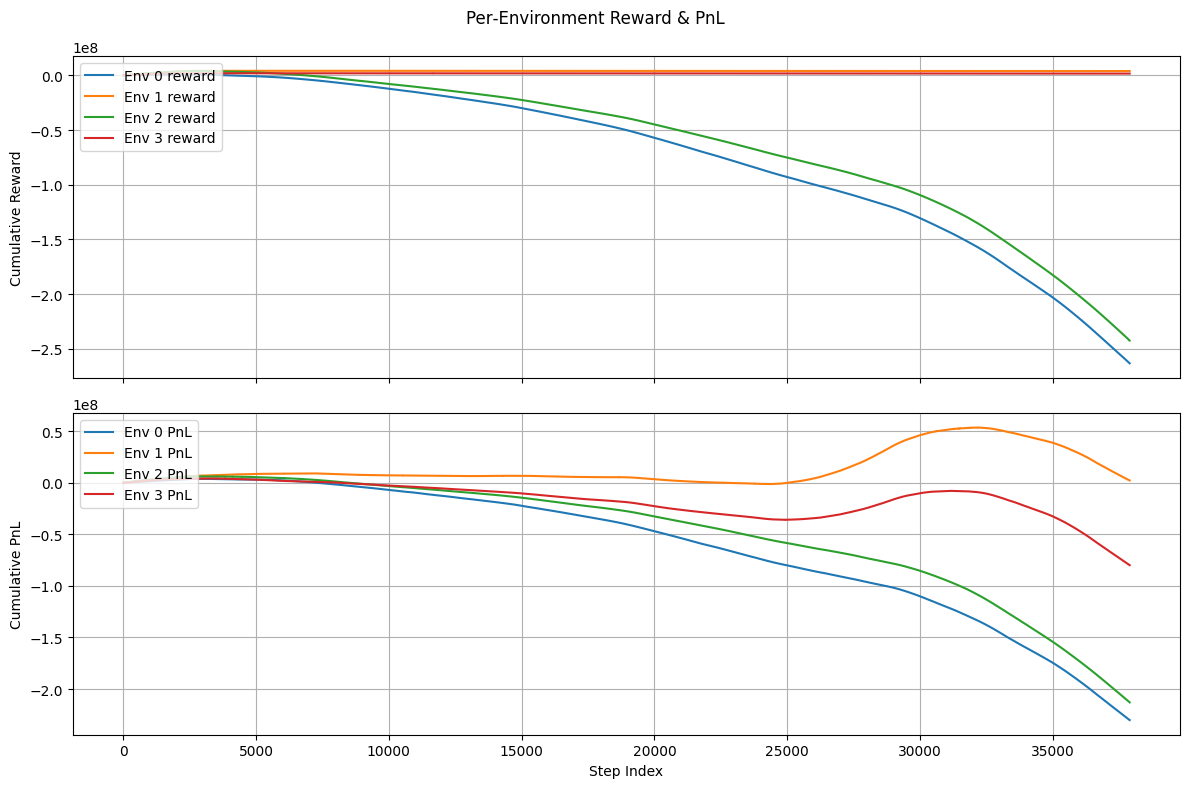

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("./training_logs/training_log.csv", parse_dates=["timestamp"])

# 1) Tag each row with an env_id
n_envs = 4
df["env_id"] = df.reset_index().index % n_envs

# 2) Compute per‐env cumulative sums
for i, g in df.groupby("env_id"):
    df.loc[g.index, "cum_reward"] = g["reward"].cumsum().values
    df.loc[g.index, "cum_pnl"]    = g["pnl"].cumsum().values

# 3) Plot them separately, e.g. in two subplots
fig, (ax_r, ax_p) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

colors = plt.cm.tab10.colors
for i in range(n_envs):
    sub = df[df.env_id == i]
    ax_r.plot(sub["step_idx"], sub["cum_reward"],
              color=colors[i], label=f"Env {i} reward")
    ax_p.plot(sub["step_idx"], sub["cum_pnl"],
              color=colors[i], label=f"Env {i} PnL")

ax_r.set_ylabel("Cumulative Reward")
ax_r.legend(loc="upper left")
ax_r.grid(True)

ax_p.set_xlabel("Step Index")
ax_p.set_ylabel("Cumulative PnL")
ax_p.legend(loc="upper left")
ax_p.grid(True)

plt.suptitle("Per‐Environment Reward & PnL")
plt.tight_layout()
plt.show()

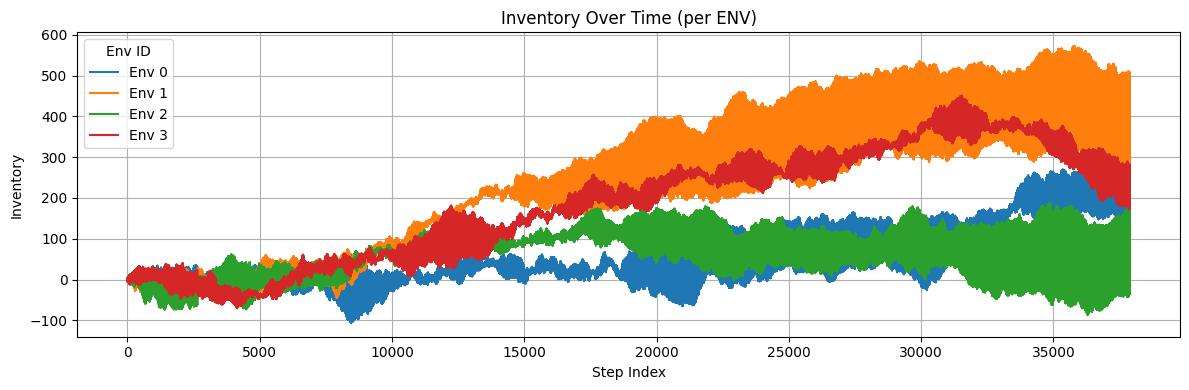

In [ ]:
# 2) Plot inventory for each env on the same axes
fig, ax = plt.subplots(figsize=(12, 4))
colors = plt.cm.tab10.colors

for i in range(n_envs):
    sub = df[df.env_id == i]
    ax.plot(sub["step_idx"], sub["inventory"],
            color=colors[i], label=f"Env {i}")

ax.set_title("Inventory Over Time (per ENV)")
ax.set_xlabel("Step Index")
ax.set_ylabel("Inventory")
ax.grid(True)
ax.legend(title="Env ID")
plt.tight_layout()
plt.show()

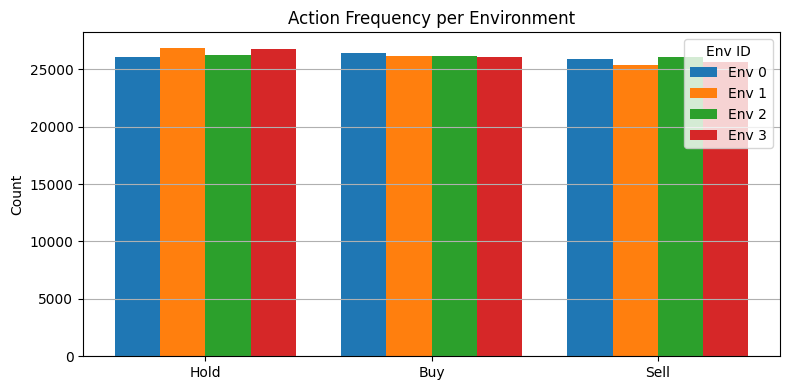

In [ ]:
import numpy as np
# action → label mapping
action_labels = {0: "Hold", 1: "Buy", 2: "Sell"}
labels = [action_labels[i] for i in sorted(action_labels)]

# get your env ids
env_ids = sorted(df["env_id"].unique())
n_envs = len(env_ids)

# x positions for the 3 actions
x = np.arange(len(labels))
width = 0.8 / n_envs   # total width 0.8 split across envs

fig, ax = plt.subplots(figsize=(8, 4))

for i, env in enumerate(env_ids):
    sub = df[df.env_id == env]
    # count each action, reindex to ensure all 3 present
    counts = sub["action"] \
        .value_counts() \
        .reindex(sorted(action_labels.keys()), fill_value=0) \
        .sort_index()
    ax.bar(x + (i - (n_envs-1)/2) * width,
           counts.values,
           width,
           label=f"Env {env}")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Count")
ax.set_title("Action Frequency per Environment")
ax.legend(title="Env ID")
ax.grid(axis="y")

fig.tight_layout()
plt.show()

In [ ]:
import importlib
import evaluation.simulation
importlib.reload(evaluation.simulation)
from evaluation.simulation import TradingDaySimulator

sim = TradingDaySimulator("./training_logs/training_log_env1.csv", skip=100)
sim.render_video("simulation_training_optimized_reward_GPRO_v1.mp4")

/content/drive/MyDrive/IE_421/agitrader/evaluation/simulation.py:158: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax_price.set_xlim(times.min(), times.max())


### **Testing**


In [ ]:
import importlib
from itertools import count
import pandas as pd
from tqdm import tqdm
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from sb3_contrib.ppo_recurrent import RecurrentPPO

import reward.reward_GRPO
import environment.lob_env
import agent.train
import evaluation.logger

importlib.reload(reward.reward_GRPO)
importlib.reload(environment.lob_env)
importlib.reload(agent.train)
importlib.reload(evaluation.logger)

from environment.lob_env import LOBEnv
from reward.reward_GRPO import RewardGRPO

# Define test dataset and log
TEST_CSV      = "./data/splits/AAPL_20250407_test.csv"
test_log_path = "./training_logs/test_log_GPRO.csv"
if os.path.exists(test_log_path):
    os.remove(test_log_path)

# Create test env (single instance)
test_env = DummyVecEnv([lambda: Monitor(
    LOBEnv(
        features_csv=TEST_CSV,
        log_path=test_log_path,
        reward_fn=RewardGRPO(
            pnl_weight=1.8,
            inventory_risk_weight=2.5,
            drawdown_weight=0.08,
            flatten_weight=0.2,
            holding_cost_weight=0.03,
            terminal_inventory_cost=6.0,
            normalize_rewards=True
        ),
        inventory_limit=100
    )
)])

# Load trained model
model = RecurrentPPO.load("./models/lob_prototype/final_model")

# Prepare to run a full test episode
n_steps = len(pd.read_csv(TEST_CSV))
obs = test_env.reset()    # returns only obs
state = None
done = False

# Run inference with a progress bar
with tqdm(total=n_steps, desc="Evaluating on test set") as pbar:
    while not done:
        action, state = model.predict(obs, state=state, deterministic=True)
        obs, reward, done, info = test_env.step(action)
        pbar.update(1)


Initialized TradingLSTMPolicy with LSTM size: 64


Evaluating on test set: 100%|█████████▉| 70218/70228 [12:23<00:00, 94.39it/s]


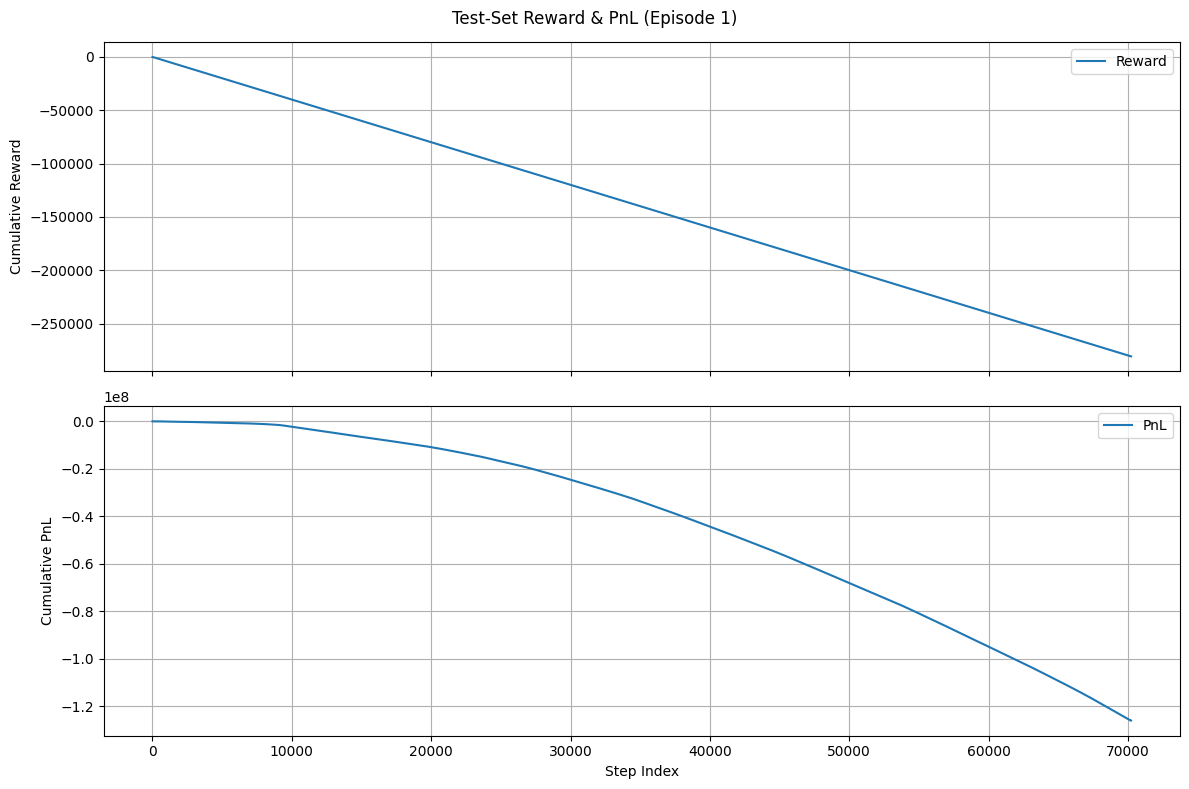

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("./training_logs/test_log_GPRO.csv", parse_dates=["timestamp"])

# only keep the first episode
df = df[df.episode_id == 1].copy()

# now cumulative sums are monotonic
df["cum_reward"] = df["reward"].cumsum()
df["cum_pnl"]    = df["pnl"].cumsum()

fig, (ax_r, ax_p) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax_r.plot(df["step_idx"], df["cum_reward"], label="Reward")
ax_p.plot(df["step_idx"], df["cum_pnl"],    label="PnL")

ax_r.set_ylabel("Cumulative Reward"); ax_r.legend(); ax_r.grid(True)
ax_p.set_ylabel("Cumulative PnL");      ax_p.legend(); ax_p.grid(True)
ax_p.set_xlabel("Step Index")

plt.suptitle("Test-Set Reward & PnL (Episode 1)")
plt.tight_layout()
plt.show()

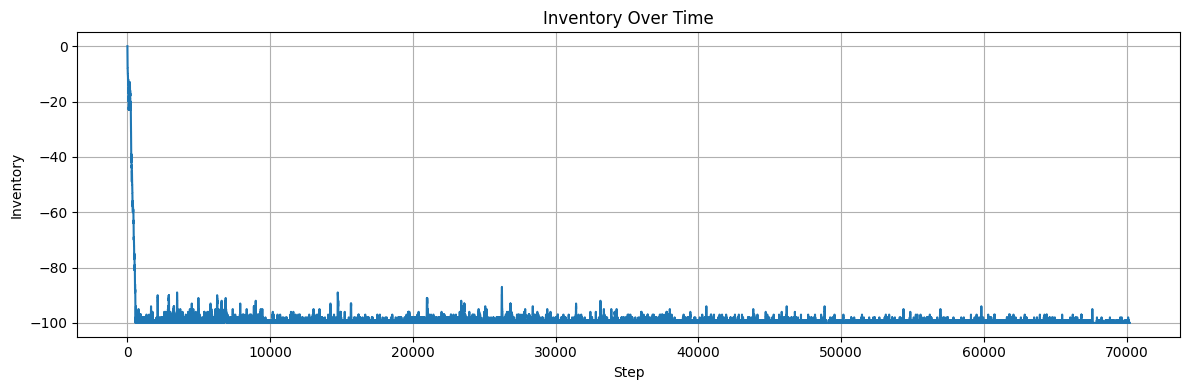

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(df["step_idx"], df["inventory"])
plt.title("Inventory Over Time")
plt.xlabel("Step")
plt.ylabel("Inventory")
plt.grid(True)
plt.tight_layout()
plt.show()

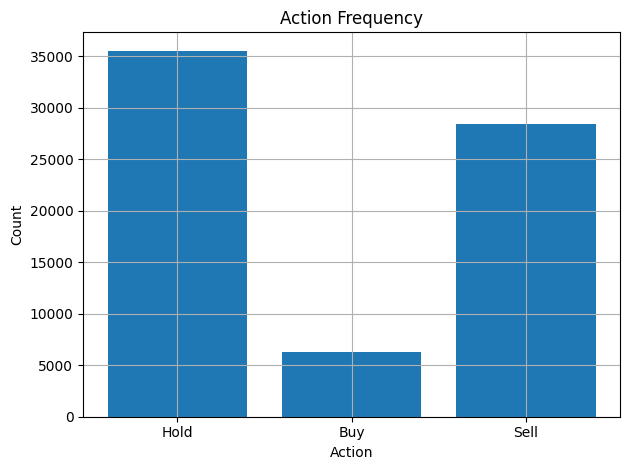

In [ ]:
action_labels = {0: "Hold", 1: "Buy", 2: "Sell"}
action_counts = df["action"].value_counts().sort_index()

plt.bar([action_labels.get(i, i) for i in action_counts.index], action_counts.values)
plt.title("Action Frequency")
plt.xlabel("Action")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import importlib
import evaluation.simulation
importlib.reload(evaluation.simulation)
from evaluation.simulation import TradingDaySimulator

sim = TradingDaySimulator("./training_logs/test_log_GPRO.csv", skip=100)
sim.render_video("simulation_test_v1.mp4")

/content/drive/MyDrive/IE_421/agitrader/evaluation/simulation.py:158: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax_price.set_xlim(times.min(), times.max())


## **PART 5 EXTENSION TO 100 SYMBOLS & 30 DAYS**

### **Generate Mock Data**

In [ ]:
import os
import csv
import random
from datetime import datetime, timedelta, timezone

# Utility to convert datetime to nanoseconds
def ns_timestamp(dt):
    return int(dt.timestamp() * 1e9)

# Configuration
output_dir = './data/test_data'
os.makedirs(output_dir, exist_ok=True)

symbols = ['AAPL', 'AMD', 'MSFT', 'META']
date_str = '2025-04-07'
n_rows = 5
depth_flags = ['R', 'Q', 'X']
sale_conditions = ['REGULAR', 'ODD_LOT', 'EXTENDED_HOURS']

# Choose a base time for event generation (UTC)
base_time = datetime.fromisoformat(date_str + "T09:30:00+00:00")

# Group by first letter and write letter-split CSVs
for letter in sorted({sym[0] for sym in symbols}):
    # Trade report file for this letter
    trd_path = os.path.join(output_dir, f"{letter}_trd.csv")
    with open(trd_path, 'w', newline='') as f_trd:
        writer = csv.writer(f_trd)
        writer.writerow([
            'timestamp', 'PacketCaptureTime', 'PacketSendTime', 'MessageID',
            'IEXTimestamp', 'TickType', 'Symbol', 'Size', 'Price',
            'TradeID', 'SaleCondition'
        ])
        for sym in symbols:
            if sym[0] == letter:
                for i in range(n_rows):
                    event_time = base_time + timedelta(milliseconds=100 * i)
                    ts = event_time.astimezone(timezone.utc).isoformat(timespec='milliseconds')
                    cap = ns_timestamp(event_time + timedelta(microseconds=random.randint(0, 1000)))
                    snd = cap - random.randint(0, 1000)
                    iex_ts = cap - random.randint(0, 1000)
                    size = random.choice([10, 50, 100, 200, 500])
                    price = round(random.uniform(100, 200), 6)
                    sc = random.choice(sale_conditions)
                    writer.writerow([
                        ts, cap, snd, random.randint(10000, 99999),
                        iex_ts, 'T', sym, size, price,
                        random.randint(1000000, 9999999), sc
                    ])
    # Price-level update file for this letter
    prl_path = os.path.join(output_dir, f"{letter}_prl.csv")
    with open(prl_path, 'w', newline='') as f_prl:
        writer = csv.writer(f_prl)
        writer.writerow([
            'timestamp', 'PacketCaptureTime', 'PacketSendTime', 'MessageID',
            'IEXTimestamp', 'TickType', 'Symbol', 'Price', 'Size',
            'RecordType', 'Flag', 'ASK'
        ])
        for sym in symbols:
            if sym[0] == letter:
                for i in range(n_rows):
                    event_time = base_time + timedelta(milliseconds=100 * i)
                    ts = event_time.astimezone(timezone.utc).isoformat(timespec='milliseconds')
                    cap = ns_timestamp(event_time + timedelta(microseconds=random.randint(0, 1000)))
                    snd = cap - random.randint(0, 1000)
                    iex_ts = cap - random.randint(0, 1000)
                    price = round(random.uniform(100, 200), 6)
                    size = random.choice([100, 200, 500, 1000])
                    rec = random.choice(depth_flags)
                    flag = random.randint(0, 1)
                    ask = random.randint(0, 1)
                    writer.writerow([
                        ts, cap, snd, random.randint(10000, 99999),
                        iex_ts, 'PRL', sym, price, size,
                        rec, flag, ask
                    ])

# List generated files
print("Generated letter-split test files:")
print(os.listdir(output_dir))

# Show a preview of the A_trd.csv
print("\nPreview of A_trd.csv:")
with open(os.path.join(output_dir, 'A_trd.csv')) as f:
    for _ in range(6):
        print(f.readline().strip())


Generated letter-split test files:
['A_trd.csv', 'A_prl.csv', 'M_trd.csv', 'M_prl.csv']

Preview of A_trd.csv:
timestamp,PacketCaptureTime,PacketSendTime,MessageID,IEXTimestamp,TickType,Symbol,Size,Price,TradeID,SaleCondition
2025-04-07T09:30:00.000+00:00,1744018200000057088,1744018200000057035,98789,1744018200000056959,T,AAPL,500,115.92193,2730553,EXTENDED_HOURS
2025-04-07T09:30:00.100+00:00,1744018200100313856,1744018200100312878,67135,1744018200100313004,T,AAPL,50,166.762795,7910576,EXTENDED_HOURS
2025-04-07T09:30:00.200+00:00,1744018200200807168,1744018200200806366,65240,1744018200200806950,T,AAPL,200,180.852362,7987173,ODD_LOT
2025-04-07T09:30:00.300+00:00,1744018200300993024,1744018200300992525,94344,1744018200300992361,T,AAPL,10,140.339285,5539362,EXTENDED_HOURS
2025-04-07T09:30:00.400+00:00,1744018200400777984,1744018200400777264,10210,1744018200400777675,T,AAPL,200,129.370107,8166016,ODD_LOT


### Parsed Data


Sample PRL file: ./data/iex_parsed_prl_trd/20250203_prl.csv


,Packet Capture Time,Send Time,Message ID,Raw Timestamp,Tick Type,Symbol,Price,Size,Record Type,Flag,ASK
0,1738587637173215000,1738587600173187907,1738587600060806529,PRL,PEP,142.00,5,R,1,0,NaN
1,1738587637200127000,1738587600200095650,1738587600054826653,PRL,CSX,32.00,5,R,1,0,NaN
2,1738587637211589000,1738587600211560134,1738587600128495201,PRL,JPM,162.50,10,R,1,0,NaN
3,1738587637228526000,1738587600228491791,1738587600137019911,PRL,AMZN,119.99,10,R,1,0,NaN
4,1738587637233194000,1738587600233168182,1738587600130761570,PRL,MSFT,365.00,10,R,1,0,NaN


Rows in that PRL file: 23207321

Sample TRD file: ./data/iex_parsed_prl_trd/20250203_trd.csv


,Packet Capture Time,Send Time,Message ID,Raw Timestamp,Tick Type,Symbol,Size,Price,Trade ID,Sale Condition
0,1738587660094572000,1738587623094534636,1738587623094242723,T,AVGO,100,213.74,12,EXTENDED_HOURS,NaN
1,1738587831875671000,1738587794875636984,1738587794875225573,T,NVDA,100,115.12,148,EXTENDED_HOURS,NaN
2,1738587831876407000,1738587794876381569,1738587794876265113,T,NVDA,100,115.12,149,EXTENDED_HOURS,NaN
3,1738587832692127000,1738587795692107592,1738587795691986099,T,NVDA,100,115.09,155,EXTENDED_HOURS,NaN
4,1738587999563747000,1738587962563706581,1738587962563466133,T,NVDA,80,115.30,304,EXTENDED_HOURS|ODD_LOT,NaN


Rows in that TRD file: 613027

Total PRL files: 1
Total TRD files: 1



<Figure size 1200x400 with 0 Axes>

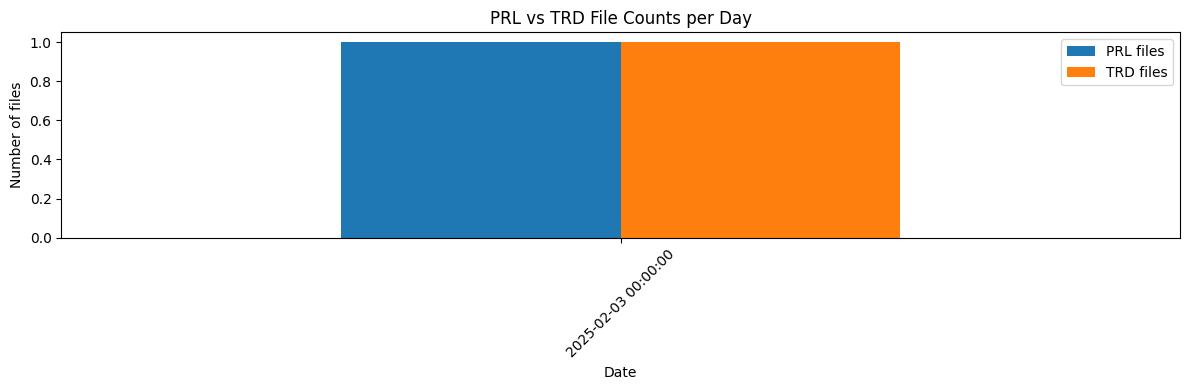

In [ ]:
# Inspect raw parsed PRL/TRD files and visualize available dates
# https://gitlab.engr.illinois.edu/ie421_high_frequency_trading_fall_2024/ie421_hft_fall_2024_group_02/group_02_project
import os
import glob
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Directory containing parsed IEX data
parsed_dir = "./data/iex_parsed_prl_trd"

# Find all PRL and TRD files (ignore txt)
prl_files = sorted(glob.glob(os.path.join(parsed_dir, "*_prl.csv")))
trd_files = sorted(glob.glob(os.path.join(parsed_dir, "*_trd.csv")))

# Print head & row count of one sample PRL file
if prl_files:
    sample_prl = prl_files[0]
    print("Sample PRL file:", sample_prl)
    df_prl = pd.read_csv(sample_prl)
    display(df_prl.head())
    print(f"Rows in that PRL file: {len(df_prl)}\n")
else:
    print("No PRL files found.\n")

# Print head & row count of one sample TRD file
if trd_files:
    sample_trd = trd_files[0]
    print("Sample TRD file:", sample_trd)
    df_trd = pd.read_csv(sample_trd)
    display(df_trd.head())
    print(f"Rows in that TRD file: {len(df_trd)}\n")
else:
    print("No TRD files found.\n")

# Print total number of files
print(f"Total PRL files: {len(prl_files)}")
print(f"Total TRD files: {len(trd_files)}\n")

# Parse dates from filenames (YYYYMMDD prefix)
prl_dates = [datetime.strptime(os.path.basename(f).split("_")[0], "%Y%m%d") for f in prl_files]
trd_dates = [datetime.strptime(os.path.basename(f).split("_")[0], "%Y%m%d") for f in trd_files]

# Count files per date
prl_counts = Counter(prl_dates)
trd_counts = Counter(trd_dates)
all_dates = sorted(set(prl_counts) | set(trd_counts))

# Build DataFrame of counts
date_index = pd.to_datetime(all_dates)
counts_df = pd.DataFrame({
    "PRL files": [prl_counts[d] for d in all_dates],
    "TRD files": [trd_counts[d] for d in all_dates]
}, index=date_index)

# Plot file counts per day
plt.figure(figsize=(12, 4))
counts_df.plot(kind="bar", figsize=(12,4))
plt.xlabel("Date")
plt.ylabel("Number of files")
plt.title("PRL vs TRD File Counts per Day")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv("./data/iex_parsed_prl_trd/20250203_prl.csv",
                 dtype={"Symbol": str})
print(df["Symbol"].unique())


['301.380000' '303.120000' '304.090000' '303.500000' '305.250000'
 '303.960000' '303.830000' '304.060000' '304.990000' '305.000000'
 '304.070000' '305.230000' '304.830000' '304.210000' '304.200000'
 '305.040000' '305.050000' '304.680000' '303.710000' '303.680000'
 '303.670000' '303.220000' '304.610000' '304.740000' '304.730000'
 '304.000000' '302.760000' '302.750000' '308.230000' '302.770000'
 '303.820000' '303.770000' '303.990000' '302.290000' '302.280000'
 '302.300000' '302.310000' '302.320000' '302.840000' '302.850000'
 '303.610000' '303.600000' '303.580000' '303.050000' '303.070000'
 '303.080000' '303.930000' '303.920000' '303.090000' '303.380000'
 '304.390000' '303.400000' '304.380000' '303.410000' '303.420000'
 '303.430000' '303.440000' '304.700000' '304.690000' '304.510000'
 '304.500000' '303.870000' '304.350000' '304.340000' '303.850000'
 '304.190000' '304.140000' '303.660000' '304.130000' '304.010000'
 '303.980000' '303.880000' '303.810000' '303.800000' '302.990000'
 '303.0000

In [ ]:
prl = pd.read_csv("/content/drive/MyDrive/IE_421/agitrader/data/iex_parsed_prl_trd/20250203_prl.csv", usecols=["Symbol"])
tickers = prl["Symbol"].astype(str).unique()
print("Tickers in that day’s PRL:", tickers)


Tickers in that day’s PRL: ['301.38' '303.12' '304.09' '303.5' '305.25' '303.96' '303.83' '304.06'
 '304.99' '305.0' '304.07' '305.23' '304.83' '304.21' '304.2' '305.04'
 '305.05' '304.68' '303.71' '303.68' '303.67' '303.22' '304.61' '304.74'
 '304.73' '304.0' '302.76' '302.75' '308.23' '302.77' '303.82' '303.77'
 '303.99' '302.29' '302.28' '302.3' '302.31' '302.32' '302.84' '302.85'
 '303.61' '303.6' '303.58' '303.05' '303.07' '303.08' '303.93' '303.92'
 '303.09' '303.38' '304.39' '303.4' '304.38' '303.41' '303.42' '303.43'
 '303.44' '304.7' '304.69' '304.51' '304.5' '303.87' '304.35' '304.34'
 '303.85' '304.19' '304.14' '303.66' '304.13' '304.01' '303.98' '303.88'
 '303.81' '303.8' '302.99' '303.0' '303.01' '303.47' '303.46' '303.45'
 '303.06' '303.86' '303.28' '303.27' '303.29' '303.3' '303.34' '303.37'
 '303.39' '303.36' '304.05' '303.55' '303.56' '303.57' '303.62' '303.64'
 '304.33' '304.54' '303.84' '304.53' '305.76' '303.89' '305.08' '305.07'
 '304.23' '304.25' '304.28' '304.3' 